# Análisis de embeddings para clasificación de noticias en medios chilenos (BOW, TDFIDF y W2V)

1) Se entrena modelo Word2Vec para español.

2) Se realiza embedding de noticas del medio "La Cuarta" y "La Tercera" utiliznado BOW, TFIDF, W2V

3) Se entrenan algoritmos de clasificación de medio considernado el corpus de forma vectorizada por cada uno de los embeddings implementados anteriormente.

4) Se analizan y comparan resultados.

### Load libraries

In [1]:
from gensim.models import word2vec
from IPython.display import display, HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Log classifier
from sklearn.model_selection import train_test_split # Split in train/test
from sklearn import metrics
import matplotlib.pyplot as plt
import gensim 
import numpy as np
import spacy
from sklearn.model_selection import StratifiedShuffleSplit # for split data (train/test)
from stop_words import get_stop_words # stop words
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier # MLP NN
from sklearn import svm # support vector machine

### Load data

In [2]:
# Analize data
# df = pd.read_csv('dataset-cuarta_vs_tercera.csv', sep = '|', header = None)
df = pd.read_csv('MAD2019_dataset_lacuarta_latercera.csv', sep = '|', header = None)

# Get news and medium
# df = df.iloc[:,[1,3]]

df = df.drop(labels = [0,2, 4], axis = 1)

# Add names
df.columns =  ['company', 'report']

# company:
# 0: La tercera
# 1: La cuarta

# Get dummies variables
dummies = pd.get_dummies(df['company'], drop_first = True)
df = pd.concat([df, dummies], axis=1) 
df.drop(['company'], inplace=True, axis=1)

# rename again
df.columns =  ['report', 'company']

# display(dummies.head())
# print(df.shape)
df.head()

,report,company
0,Esto te interesa... 22/05/2017 - Autor: La Cu...,0
1,Esto te interesa... 01/06/2017 - Autor: Docto...,0
2,Siempre estuve esperando que llegara una muje...,0
3,Esto te interesa... 02/03/2017 - Autor: Claud...,0
4,Junto a Nachito Pop revivimos paso a paso la ...,0


In [3]:
# # Taking smaller data
df = df.sample(3000)
df.reset_index(inplace = True)

In [4]:
# Displaying shape
display(df.shape)
df.head()

(3000, 3)

,index,report,company
0,3328,La muerte de Chris Cornell recuerda a otros q...,1
1,4625,Un post en el grupo de Facebook de Australian...,1
2,159,Esto te interesa... 11/08/2017 - Autor: LaCua...,0
3,733,Esto te interesa... 23/07/2017 - Autor: Docto...,0
4,1790,"El Chile que somos. Noticias, conversación, o...",1


### Analize classes (for check balancing)

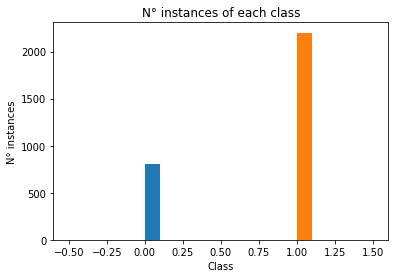

In [5]:
# Distribution of labels
fig, ax = plt.subplots()

# plot hist
ax.hist(df.loc[df['company'] == 0, 'company'], bins = 10)
ax.hist(df.loc[df['company'] == 1, 'company'], bins = 10)
ax.set_xlabel('Class')
ax.set_ylabel('N° instances')
ax.title.set_text('N° instances of each class')

Se tienen clases desbalanceadas, ya que la clase 'La tercera', posee mas instancias que la otra clase. Por lo que hay que tener precausión en su procesamiento, ya que por ejemplo, si se utilizara accuracy en clasificación, esta métrica no sería del todo correcta para comparar métodos.

### Define tokenizer of corpus

In [6]:
# Tokenizer

# Define own tokenizer

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

# BOW and TFIDF development

### Stopwords to use in tokenizer

In [7]:
# Stop words (not has information)
stop_words = ['a','e','i','o','u',' ','  ','   ','  ','$','  ','y', '-', 'q','c', 'nna', 'e', 'l', '=', '<', '>','x','href','/',
             'JavaScript', 'navegador', '¿', 'Twitter', 'Tweets', 'web', 'URL']

# using stop words from library
stop_words_lib = get_stop_words('spanish')

# joining stop words
stop_words = stop_words + stop_words_lib

### Create vectorizer of BOW and TFIDF

In [8]:
# Vectorizer

# Bag of words
bow_vector = CountVectorizer(tokenizer = own_tokenizer, ngram_range = (1,1))

# TFIDF
tfidf_vector = TfidfVectorizer(tokenizer = own_tokenizer, ngram_range = (1,1))

### Get data individally

In [9]:
# Get data
X = df['report'] # the features we want to analyze
y = df['company'] # the labels, or answers, we want to test against

### Crate pipelines for BOW and TFIDF:

1) Apply the vectorization

2) Model to use

In [10]:
# Create pipelines

# Bag of words

# Create pipeline using logistic regression
pipe_bow_log = Pipeline([('bow vectorizer', bow_vector),
                 ('logistic regression', LogisticRegression(solver = 'lbfgs'))])

# Using extra trees classifier (it's base in decision tree (It's like a forest))
pipe_bow_extra_trees = Pipeline([
    ("bow vectorizer", bow_vector),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# using MLP
pipe_bow_MLP = Pipeline([
    ("bow vectorizer", bow_vector),
    ("MLP", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1))
])

# Using SVM
pipe_bow_SVM = Pipeline([
    ("bow vectorizer", bow_vector),
    ("SVM", svm.SVC(gamma='scale'))
])

# TFIDF

# log reg using tfidf
pipe_tfidf_log = Pipeline([('tfidf vectorizer', tfidf_vector),
                 ('logistic regression', LogisticRegression(solver = 'lbfgs'))])

# Using extra trees classifier (it's base in decision tree (It's like a forest))
pipe_tfidf_extra_trees = Pipeline([
    ("tfidf vectorizer", tfidf_vector),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# using MLP
pipe_tfidf_MLP = Pipeline([
    ("tfidf vectorizer", tfidf_vector),
    ("MLP", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1))
])

# Using SVM
pipe_tfidf_SVM = Pipeline([
    ("tfidf vectorizer", tfidf_vector),
    ("SVM", svm.SVC(gamma='scale'))
])


# LIST OF MODELS

# list of models
models_bow_tfidf = [
    ('bow + log reg', pipe_bow_log),
    ('bow + ext_tree', pipe_bow_extra_trees),
    ('bow + MLP', pipe_bow_MLP),
    ('bow + SVM', pipe_bow_SVM),
    
    ('tfidf + log reg', pipe_tfidf_log),
    ('tfidf + ext_tree', pipe_tfidf_extra_trees),
    ('tfidf + MLP', pipe_tfidf_MLP),
    ('tfidf + SVM', pipe_tfidf_SVM)
    
]

### Train each model (bow and tfidf) considering differentes sizes of trainig data. In each training, it gets the accuracy of each model and store in scores

In [11]:
# train model function (this was done for parallelizing models)
def train_model(item):
    
    name = item[0]
    model = item[1]
    
    print('Train model {0} with PID: {1}'.format(name, os.getpid()))
    
    # restart scores for each model
    score = []
    
    # differents size of training examples
    num_train = np.linspace(start = 2, stop = y.size - 10, num = 5).astype(int)
    
    # iterate over each train size
    for train_size in num_train:

        print('train size of {0}: {1}\n'.format(name, train_size))

        test_size = 1 - (train_size / float(len(y)))

        sp = StratifiedShuffleSplit(n_splits=1, test_size = test_size)

        sp.get_n_splits(X, y)

        for train, test in sp.split(X, y):

            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]

            acc = (metrics.accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))

            score.append(acc)
    
        
    # add scores to list
    results = {
        'name': name,
        'accuracy': score
    }
        
    return results

In [12]:
# Train models

# using parallelism
import multiprocessing as mp
import os

# Init pool of process
pool = mp.Pool(mp.cpu_count())

# Exec function in each process
scores_bow_tfidf = pool.map(train_model, models_bow_tfidf)

Train model bow + SVM with PID: 5925
Train model bow + MLP with PID: 5924
Train model bow + log reg with PID: 5922
Train model tfidf + log reg with PID: 5926
Train model tfidf + MLP with PID: 5928
Train model tfidf + ext_tree with PID: 5927
Train model tfidf + SVM with PID: 5929
Train model bow + ext_tree with PID: 5923
train size of tfidf + MLP: 2
train size of tfidf + log reg: 2
train size of bow + SVM: 2
train size of bow + ext_tree: 2
train size of bow + MLP: 2
train size of tfidf + SVM: 2
train size of tfidf + ext_tree: 2
train size of bow + log reg: 2








train size of tfidf + ext_tree: 749

train size of tfidf + SVM: 749

train size of bow + ext_tree: 749

train size of bow + log reg: 749

train size of tfidf + log reg: 749

train size of bow + MLP: 749

train size of bow + SVM: 749

train size of tfidf + MLP: 749



/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


train size of tfidf + log reg: 1496
train size of tfidf + ext_tree: 1496


train size of bow + ext_tree: 1496

train size of bow + log reg: 1496

train size of tfidf + SVM: 1496

train size of bow + SVM: 1496

train size of tfidf + MLP: 1496

train size of bow + MLP: 1496



/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


train size of tfidf + log reg: 2243

train size of tfidf + ext_tree: 2243

train size of bow + ext_tree: 2243

train size of bow + log reg: 2243

train size of tfidf + SVM: 2243

train size of bow + SVM: 2243

train size of tfidf + MLP: 2243

train size of bow + MLP: 2243



/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


train size of tfidf + log reg: 2990

train size of tfidf + ext_tree: 2990

train size of bow + ext_tree: 2990

train size of bow + log reg: 2990

train size of tfidf + SVM: 2990

train size of bow + SVM: 2990

train size of tfidf + MLP: 2990

train size of bow + MLP: 2990



/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Word2Vec development

### get data in format to w2v (tokenize each doc)

In [13]:
# Tokenize each doc
X_w2v = [ own_tokenizer(report) for report in df['report']]

In [14]:
# Transform list to ndarray
X_w2v = np.array(X_w2v)

### Get w2v model and the representation of each word in w2v

In [15]:
# dimensions of w2v
w2v_dim = 500

# Create w2v model
model_w2v = gensim.models.Word2Vec(X_w2v, size = w2v_dim)

# Dictionary: key: each word, value: its w2v representation (vector)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


### Embedding of each doc (to format w2v)

In [16]:
# Embedding of docs using w2v
# this get a vector of each document of dimension (dimension_vector_w2v, 1), so the total array is (n_docs, dimension_vector_w2v)
class MeanEmbeddingVectorizer(object):
      
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        
        # This mean each dimension of each word in doc, it getting the w2v representation of each doc
        doc_w2v = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        
#         print(doc_w2v.shape)
#         print(doc_w2v)
        # Return vlaue
        return doc_w2v
    

### Pipelines for w2v:

1) Apply w2v transformation

2) Apply model to use

In [17]:
# pipe for traing using w2v

# using logistic regression
pipe_word2vec_log = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("logistic regression", LogisticRegression(solver = 'lbfgs'))])

# Using extra trees classifier (it's base in decision tree (It's like a forest))
pipe_word2vec_extra_trees = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# using MLP
pipe_word2vec_MLP = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("MLP", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1))
])

# Using SVM
pipe_word2vec_SVM = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("SVM", svm.SVC(gamma='scale'))
])

# list of models
# Add new model here
models_w2v = [
    ('w2v + log reg', pipe_word2vec_log), 
    ('w2v + ext_trees', pipe_word2vec_extra_trees), 
    ('w2v + MLP', pipe_word2vec_MLP),
    ('w2v + SVM', pipe_word2vec_SVM),
]

### Train each model using w2v representation. Training is by differentes training sizes. For each model, it gets the accuracy and add it to score list

In [18]:
# train model function (this was done for parallelizing models)
def train_model_w2v(item):
    
    name = item[0]
    model = item[1]
    
    print('Train model {0} with PID: {1}'.format(name, os.getpid()))
    
    # restart scores for each model
    score = []
    
    # differents size of training examples
    num_train = np.linspace(start = 2, stop = y.size - 10, num = 5).astype(int)
    
    # iterate over each train size
    for train_size in num_train:

        print('train size of {0}: {1}\n'.format(name, train_size))

        test_size = 1 - (train_size / float(len(y_w2v)))

        sp = StratifiedShuffleSplit(n_splits=1, test_size = test_size)

        sp.get_n_splits(X_w2v, y_w2v)

        for train, test in sp.split(X_w2v, y_w2v):

            X_train_w2v, X_test_w2v = X[train], X[test]
            y_train_w2v, y_test_w2v = y[train], y[test]
            
            acc = (metrics.accuracy_score(model.fit(X_train_w2v, y_train_w2v).predict(X_test_w2v), y_test_w2v))

            score.append(acc)
    
        
    # add scores to list
    results = {
        'name': name,
        'accuracy': score
    }
        
    return results

In [19]:
# Train models

# using parallelism
import multiprocessing as mp
import os

# get labels
y_w2v = df['company']

# Init pool of process
pool = mp.Pool(mp.cpu_count())

# Exec function in each process
scores_w2v = pool.map(train_model_w2v, models_w2v)

Train model w2v + log reg with PID: 6436
Train model w2v + ext_trees with PID: 6435
train size of w2v + log reg: 2
train size of w2v + ext_trees: 2


Train model w2v + MLP with PID: 6432
train size of w2v + MLP: 2

Train model w2v + SVM with PID: 6434
train size of w2v + SVM: 2

train size of w2v + log reg: 749
train size of w2v + SVM: 749


train size of w2v + ext_trees: 749

train size of w2v + MLP: 749

train size of w2v + log reg: 1496

train size of w2v + SVM: 1496

train size of w2v + ext_trees: 1496

train size of w2v + log reg: 2243

train size of w2v + SVM: 2243

train size of w2v + ext_trees: 2243

train size of w2v + log reg: 2990

train size of w2v + MLP: 1496

train size of w2v + ext_trees: 2990

train size of w2v + SVM: 2990

train size of w2v + MLP: 2243

train size of w2v + MLP: 2990



In [20]:
# Join scores
scores = scores_bow_tfidf + scores_w2v

### Analyze results

### Compare results from bow, tfidf and w2v

Text(0, 0.5, 'Accuracy')

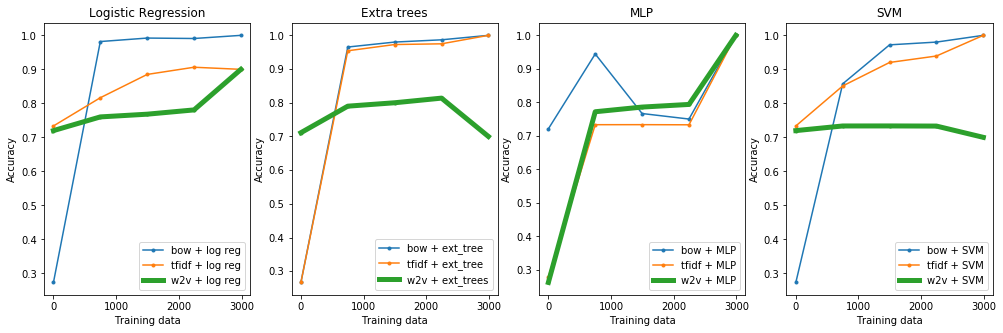

In [21]:
# define x axis values
num_train = np.linspace(start = 2, stop = y.size - 10, num = 5).astype(int)

# Crate figure
fig, ax = plt.subplots(1,4, figsize = (17,5))

# Log regression
num = 0
ax[num].plot(num_train, next(item for item in scores if item["name"] == "bow + log reg")['accuracy'], label = next(item for item in scores if item["name"] == "bow + log reg")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "tfidf + log reg")['accuracy'], label = next(item for item in scores if item["name"] == "tfidf + log reg")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "w2v + log reg")['accuracy'], linewidth = 5, label = next(item for item in scores if item["name"] == "w2v + log reg")['name'], marker = '.')
ax[num].legend()
ax[num].title.set_text('Logistic Regression')
ax[num].set_xlabel('Training data')
ax[num].set_ylabel('Accuracy')

# extra trees
num = 1
ax[num].plot(num_train, next(item for item in scores if item["name"] == "bow + ext_tree")['accuracy'], label = next(item for item in scores if item["name"] == "bow + ext_tree")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "tfidf + ext_tree")['accuracy'], label = next(item for item in scores if item["name"] == "tfidf + ext_tree")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "w2v + ext_trees")['accuracy'], linewidth = 5,label = next(item for item in scores if item["name"] == "w2v + ext_trees")['name'], marker = '.')
ax[num].legend()
ax[num].title.set_text('Extra trees')
ax[num].set_xlabel('Training data')
ax[num].set_ylabel('Accuracy')

# MLP
num = 2
ax[num].plot(num_train, next(item for item in scores if item["name"] == "bow + MLP")['accuracy'], label = next(item for item in scores if item["name"] == "bow + MLP")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "tfidf + MLP")['accuracy'], label = next(item for item in scores if item["name"] == "tfidf + MLP")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "w2v + MLP")['accuracy'], linewidth = 5,label = next(item for item in scores if item["name"] == "w2v + MLP")['name'], marker = '.')
ax[num].legend()
ax[num].title.set_text('MLP')
ax[num].set_xlabel('Training data')
ax[num].set_ylabel('Accuracy')

# MLP
num = 3
ax[num].plot(num_train, next(item for item in scores if item["name"] == "bow + SVM")['accuracy'], label = next(item for item in scores if item["name"] == "bow + SVM")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "tfidf + SVM")['accuracy'], label = next(item for item in scores if item["name"] == "tfidf + SVM")['name'], marker = '.')
ax[num].plot(num_train, next(item for item in scores if item["name"] == "w2v + SVM")['accuracy'], linewidth = 5,label = next(item for item in scores if item["name"] == "w2v + SVM")['name'], marker = '.')
ax[num].legend()
ax[num].title.set_text('SVM')
ax[num].set_xlabel('Training data')
ax[num].set_ylabel('Accuracy')

### Discusion

#### Regresión logística:

Para el caso de embedding utilizando BOW, se requiere solamente 50 ejemplos para alcanzar accuracy altos (superiores a 0,9) y que agregar mas datos para este problema de clasificación logra aumentar el acurracy pero en poca cantidad. Al tener el máximo número de datos de entrenamiento (Se escogen 10 menos que el maximo conjunto de datos), el modelo tiende a sobreajustarse al training set por lo que disminuye el accuracy sobre el testing set. 

Utilizando TFIDF se obtiene accuracies menores que BOW, lo que sugiere que en esta tarea de clasificación, hacer un embedding que de importancia a las palabras mas relevantes (palabras que logran diferenciar entre documentos) no aporta para la clasificación con logistic regression.

Finalmente, para el caso de w2v, se tienen accuracies cercanas a 0,7, las cuales son las menores comparadas con BOW y TFIDF (para 50 o mas datos de entrenamiento). Esto sugiere que el embedding usando w2v no aporta para esta tarea de clasificación, lo que significa que el algoritmo no considera relevante el significado de las palabras (propósito de w2v) para clasificar por medios. 

Por otro lado, cabe destacar que w2v mantuvo un accuracy cercano a 0,7 para todo conjunto de datos (incluyendo 2 datos de entrenamiento), sin embargo los otros embeddings poseen menores accuracies para pocos datos de entrenamiento.

#### Extra trees

Utilizando BOW y TFIDF se obtiene accuracies similares para todo tamaño de conjunto de entrenamiento. En cambio, utilizando w2v, se tienen nuevamente acurracies cercanas a 0,7, lo que sugiere que el algoritmo no considera relevante el significado de las palabras para clasificar.

#### MLP

Nuevamente BOW y TFIDF poseen accuracies similares, sin embargo BOW obtiene en mayores accuracies para algunos largos de train data específicos (50). Para el caso de w2v se tienen accuracies mas irregulares que en los otros algoritmos, ya que varía entre 0,35 y 0,68. Sin embargo para todo largo de train size se tiene que W2V posee menor accuracy que los otros embeddings.

#### SVM

En este caso, TFIDF posee mayor accuracy que los otros embeddings (excepto para 50). Para el caso de BOW, se tiene menores accuracies que TFIDF. Y para el caso de W2V, para todo largo se tienen menores accuracies, excepto para largo pequeño, en donde los 3 embeddings poseens acurracies similares.

#### Conclusiones generales

De los resultados y del análisis obtenido, se tiene que para la tarea de clasificación actual, utilizar embeddings BOW o TFIDF permite obtener mayores accuracies que utilizando W2V. Esto implica que en los algoritmos utilizados, estos no consideran relevante la información del significado de las palabras, ya que se obtienen menores accuracies utilizando W2V y, por otro lado, solo realizando un conteo de las palabras dentro de los documentos (BOW) se pueden obtener altos valores de accuracies.